In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")

/anaconda2/envs/py36-test/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
5,162,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
6,183,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
7,207,2009091000,PIT,TEN,TEN,away,PIT,TEN,94.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8,228,2009091000,PIT,TEN,TEN,away,PIT,TEN,96.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
9,253,2009091000,PIT,TEN,PIT,home,TEN,TEN,43.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [11]:
feats = list(df.columns)
feats

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

In [126]:
def analysis(data):
    fig1, axs1 = plt.pyplot.subplots(1,3,figsize=(15,3.5))
    print ("PlayTypes:", set(data.play_type))
    data.play_type.value_counts().plot('bar',title="PlayType Histogram",ax=axs1[0])
    sg = data.play_type.where(data.shotgun == 1)
    n_sg = data.play_type.where(data.shotgun == 0)
    sg.value_counts().plot('bar',title="PlayType Histogram (Shotgun)",ax=axs1[1])
    n_sg.value_counts().plot('bar',title="PlayType Histogram (QB Under Center)",ax=axs1[2])
    
    fig2, axs2 = plt.pyplot.subplots(1,1,figsize=(10,5))
    types = ["pass","run","field_goal","other"]
    td_pr_pass = data.td_prob.where(data.play_type == "pass")
    td_pr_run = data.td_prob.where(data.play_type == "run")
    td_pr_fg = data.td_prob.where(data.play_type == "field_goal")
    td_pr_other = data.td_prob.where((data.play_type != "pass") & (data.play_type != "run") & (data.play_type != "field_goal"))
    axs2.hist([td_pr_pass,td_pr_run,td_pr_fg,td_pr_other],density=True,histtype='bar',label=types)
    axs2.set_title("Touchdown Prob")
    axs2.set_xlabel("Probability")
    axs2.legend()
    

PlayTypes: {nan, 'no_play', 'field_goal', 'qb_spike', 'pass', 'extra_point', 'qb_kneel', 'punt', 'run', 'kickoff'}


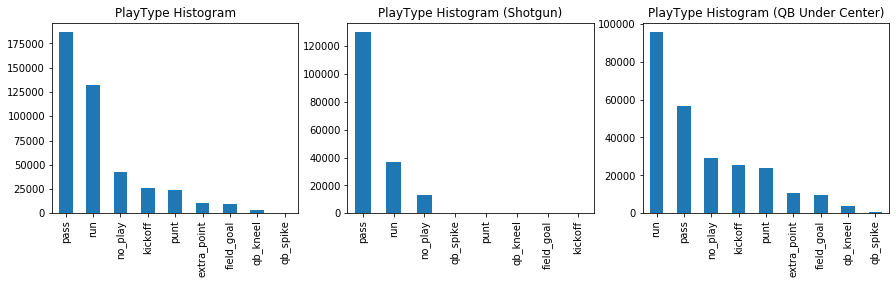

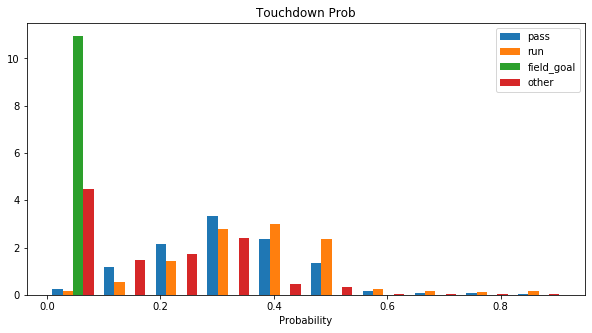

In [127]:
analysis(df)